# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random
from sklearn.preprocessing import FunctionTransformer, Imputer, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import StratifiedShuffleSplit
import pickle

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, Pipeline

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

#import custom module
from etl import etl
from ml import unsupervised_ml as usml
from ml import supervised_ml as sml
from etl.etl import DummiesTransformer

import warnings
warnings.filterwarnings("ignore")

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# Present Data Location in Udacity.

# load in the data.
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';', low_memory=False)
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';', low_memory=False)

In [3]:
#Shape and head of general data
print("General population shape {}.".format(azdias.shape))
azdias.head()

General population shape (891221, 366).


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [4]:
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [5]:
#Shape and head of customers data
print("Customers shape {}.".format(customers.shape))
customers.head()

Customers shape (191652, 369).


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [6]:
customers.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,191652.000000,191652.000000,145056.000000,145056.000000,11766.000000,5100.000000,1275.000000,236.000000,139810.000000,141725.000000,...,143781.000000,143781.000000,143781.000000,137910.000000,145056.000000,141725.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,95826.500000,0.344359,1.747525,11.352009,12.337243,13.672353,14.647059,15.377119,10.331579,4.965863,...,4.374417,4.564769,3.168868,4.152716,8.646371,3.723133,2.576806,0.090247,1.376432,3.060907
std,55325.311233,1.391672,1.966334,6.275026,4.006050,3.243335,2.753787,2.307653,4.134828,14.309694,...,2.924355,2.887035,2.233516,1.974375,1.154001,2.095540,1.168486,0.286536,0.484492,1.086254
min,1.000000,-1.000000,1.000000,0.000000,2.000000,2.000000,5.000000,8.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,47913.750000,-1.000000,1.000000,8.000000,9.000000,11.000000,13.000000,14.000000,9.000000,1.000000,...,2.000000,2.000000,1.000000,2.000000,9.000000,2.000000,1.000000,0.000000,1.000000,3.000000
50%,95826.500000,0.000000,1.000000,11.000000,13.000000,14.000000,15.000000,16.000000,10.000000,1.000000,...,4.000000,4.000000,3.000000,5.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
75%,143739.250000,2.000000,1.000000,16.000000,16.000000,16.000000,17.000000,17.000000,13.000000,4.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,5.000000,3.000000,0.000000,2.000000,4.000000
max,191652.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,523.000000,...,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000


## Preprocessing

### Assess Missing Data

#### Create missing value keys dictionary from 'DIAS Attributs - Values 2017.xlsx'

 - 1. 'DIAS Attributes - Values 2017.xlsx' file was converted to csv file 'DIAS_Attributes_Values_2017.csv'. 
 - 2. create_missing_code_dict function is created to create dictionary of missings keys for attributes


In [7]:
missing_keys_dict = etl.create_missing_key_dict("./data/DIAS_Attributes_Values_2017.csv")

#assess initially missing data
ini_missing = etl.get_missing_by_column(azdias)

#### Convert Missing Value Codes to NaNs

In [8]:
etl.convert_keys_to_nan(azdias, missing_keys_dict)

Attribute BIP_FLAG is not available in DataFrame.
Attribute CAMEO_DEUINTL_2015 is not available in DataFrame.
Attribute D19_KK_KUNDENTYP is not available in DataFrame.
Attribute GEOSCORE_KLS7 is not available in DataFrame.
Attribute HAUSHALTSSTRUKTUR is not available in DataFrame.
Attribute KBA13_CCM_1400_2500 is not available in DataFrame.
Attribute SOHO_FLAG is not available in DataFrame.
Attribute WACHSTUMSGEBIET_NB is not available in DataFrame.
Attribute D19_BUCH is not available in DataFrame.
Attribute D19_KINDERARTIKELD19_KOSMETIK is not available in DataFrame.


Note that not of all attributes that are listed in DIAS_Attributes_Values_2017 file are present in AZDIAS dataset

#### Assess Missing Data in Each Column

In [9]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
sorted_missing_info = etl.create_missing_info_df(azdias, ini_missing)
print(sorted_missing_info.round(2)[:20])

                  Attribute  ini_missing  final_missing  percent_missing
7               ALTER_KIND4       890016         890016            99.86
349                TITEL_KZ        73499         889061            99.76
6               ALTER_KIND3       885051         885051            99.31
33         D19_BANKEN_LOKAL            0         874745            98.15
5               ALTER_KIND2       861722         861722            96.69
43           D19_DIGIT_SERV            0         857661            96.23
41             D19_BIO_OEKO            0         854074            95.83
79          D19_TIERARTIKEL            0         852220            95.62
63   D19_NAHRUNGSERGAENZUNG            0         852176            95.62
47               D19_GARTEN            0         851626            95.56
60         D19_LEBENSMITTEL            0         837914            94.02
95        D19_WEIN_FEINKOST            0         836142            93.82
45              D19_ENERGIE            0         82

Distribution of missing values in AZDIAS dataset


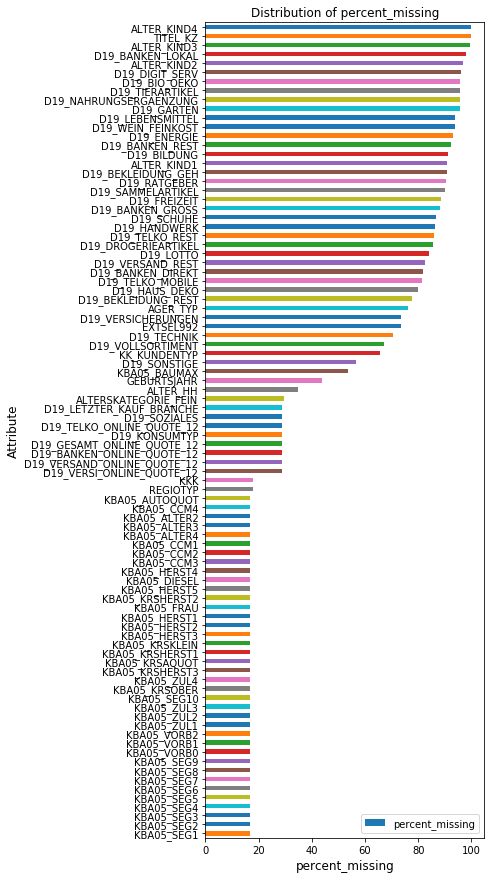

In [10]:
#plot barh plot of final missing values in Azdias
print("Distribution of missing values in AZDIAS dataset")
etl.plot_attribute_distribution(sorted_missing_info, "Attribute", "percent_missing", 90)

In [11]:
#print attributes with more than 30% percent of missing data
deleted_columns_1 = sorted_missing_info[sorted_missing_info["percent_missing"]>30]["Attribute"].values
print (len(deleted_columns_1))
print (list(deleted_columns_1))
print (sorted_missing_info[sorted_missing_info["percent_missing"]>30]["percent_missing"].values.round(2))

41
['ALTER_KIND4', 'TITEL_KZ', 'ALTER_KIND3', 'D19_BANKEN_LOKAL', 'ALTER_KIND2', 'D19_DIGIT_SERV', 'D19_BIO_OEKO', 'D19_TIERARTIKEL', 'D19_NAHRUNGSERGAENZUNG', 'D19_GARTEN', 'D19_LEBENSMITTEL', 'D19_WEIN_FEINKOST', 'D19_ENERGIE', 'D19_BANKEN_REST', 'D19_BILDUNG', 'ALTER_KIND1', 'D19_BEKLEIDUNG_GEH', 'D19_RATGEBER', 'D19_SAMMELARTIKEL', 'D19_FREIZEIT', 'D19_BANKEN_GROSS', 'D19_SCHUHE', 'D19_HANDWERK', 'D19_TELKO_REST', 'D19_DROGERIEARTIKEL', 'D19_LOTTO', 'D19_VERSAND_REST', 'D19_BANKEN_DIREKT', 'D19_TELKO_MOBILE', 'D19_HAUS_DEKO', 'D19_BEKLEIDUNG_REST', 'AGER_TYP', 'D19_VERSICHERUNGEN', 'EXTSEL992', 'D19_TECHNIK', 'D19_VOLLSORTIMENT', 'KK_KUNDENTYP', 'D19_SONSTIGE', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']
[99.86 99.76 99.31 98.15 96.69 96.23 95.83 95.62 95.62 95.56 94.02 93.82
 93.11 92.21 91.24 90.9  90.81 90.33 90.   88.73 88.12 86.74 86.22 85.95
 85.39 83.92 82.41 81.78 81.55 80.01 77.7  76.02 73.46 73.4  70.7  67.32
 65.6  56.77 53.47 44.02 34.81]


In this step I have identified the columns with missing values (np.NaN). The analysis demonstrates that most of the columns have less than 30% of missing data while there are 41 attributes with more than 30% of missing data. Among these attributes are 'ALTER_KIND4', 'TITEL_KZ', 'ALTER_KIND3', 'D19_BANKEN_LOKAL', 'ALTER_KIND2', 'D19_DIGIT_SERV', 'D19_BIO_OEKO', 'D19_TIERARTIKEL', 'D19_NAHRUNGSERGAENZUNG', 'D19_GARTEN', 'D19_LEBENSMITTEL', 'D19_WEIN_FEINKOST', 'D19_ENERGIE', 'D19_BANKEN_REST', 'D19_BILDUNG', 'ALTER_KIND1', 'D19_BEKLEIDUNG_GEH', 'D19_RATGEBER', 'D19_SAMMELARTIKEL', 'D19_FREIZEIT', 'D19_BANKEN_GROSS', 'D19_SCHUHE', 'D19_HANDWERK', 'D19_TELKO_REST', 'D19_DROGERIEARTIKEL', 'D19_LOTTO', 'D19_VERSAND_REST', 'D19_BANKEN_DIREKT', 'D19_TELKO_MOBILE', 'D19_HAUS_DEKO', 'D19_BEKLEIDUNG_REST', 'AGER_TYP', 'D19_VERSICHERUNGEN', 'EXTSEL992', 'D19_TECHNIK', 'D19_VOLLSORTIMENT', 'KK_KUNDENTYP', 'D19_SONSTIGE', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH'. These 41 attributes will be dropped from analysis.


Besides that, the attributes with similar amount of missing data were identified:
    
    158064  (%17.74): KKK, REGIOTYP
    148115 (%16.62):  most of KBA_05 features
    133324 (%14.96): all RR3 micro-cell features (KBA05_ANTG3, KBA05_ANTG1, KBA05_ANTG2, KBA05_GBZ, KBA05_ANTG4, MOBI_REGIO) 
    116515 (%13.07): all PLZ8 macro-cell features (PLZ8_ANTG2, PLZ8_ANTG1, PLZ8_ANTG3, PLZ8_ANTG4, PLZ8_BAUMAX, PLZ8_HHZ, PLZ8_GBZ)
    111196 missing by code (%12.48): VERS_TYP, SHOPPER_TYP, HEALTH_TYP
    SEMIO_, FINANZ_, AGER_TYP, ALTERSKATEGORIE_GROB, ANREDE_KZ, GEBURTSJAHR, GREEN_AVANTGARDE,
    HEALTH_TYP, NATIONALITAET_KZ and PRAEGENDE_JUGENDJAHRE attributes with zero missing features.

#### Drop columns####
Drop columns with more than 30% percent of missing values listed in list of deleted_columns (41 coulmns) need to be dropped.

Additionally we will drop the columns that are unique, categorical with more than 10 categories (however we will keep CAMEO_INTL_2015), binary with more than 70 percent of one value, with repetition from another feature, and some attributes which do not have explanation in info file.   


To identified these columns I have created attribute_types.csv file where type and action with each of attributes is addressed. Also the type for missing discription attributes that is not similar to any listed attributes is taken as categorical. These unknown atributes are listed with question mark infront of type.
    

In [12]:
att_type = pd.read_csv('./data/attribute_types.csv', sep=',')
att_type.head()

#attributes that needs to be dropped
deleted_columns_2 = att_type[att_type["action"].isin(["drop"])]["attribute"].values
print("Additional attributes that needs to be dropped: \n"
      "{}.".format(deleted_columns_2))
print("")


Additional attributes that needs to be dropped: 
['LNR' 'ANZ_HH_TITEL' 'ANZ_KINDER' 'ANZ_TITEL' 'CAMEO_DEU_2015'
 'GEBAEUDETYP' 'GEBURTSJAHR' 'KBA05_MODTEMP' 'LP_FAMILIE_FEIN'
 'LP_LEBENSPHASE_FEIN' 'LP_LEBENSPHASE_GROB' 'LP_STATUS_FEIN' 'PLZ8_ANTG1'
 'PLZ8_ANTG2' 'PLZ8_ANTG3' 'PLZ8_ANTG4' 'VERDICHTUNGSRAUM' 'VK_DHT4A'
 'VK_DISTANZ' 'VK_ZG11' 'ALTERSKATEGORIE_FEIN' 'D19_TELKO_ONLINE_QUOTE_12'
 'D19_LETZTER_KAUF_BRANCHE' 'D19_VERSI_ONLINE_QUOTE_12'].



In [13]:
deleted_columns = list(deleted_columns_1) + list(deleted_columns_2)
print("List of columns that wiil be deleted: \n{}.".format(deleted_columns))

List of columns that wiil be deleted: 
['ALTER_KIND4', 'TITEL_KZ', 'ALTER_KIND3', 'D19_BANKEN_LOKAL', 'ALTER_KIND2', 'D19_DIGIT_SERV', 'D19_BIO_OEKO', 'D19_TIERARTIKEL', 'D19_NAHRUNGSERGAENZUNG', 'D19_GARTEN', 'D19_LEBENSMITTEL', 'D19_WEIN_FEINKOST', 'D19_ENERGIE', 'D19_BANKEN_REST', 'D19_BILDUNG', 'ALTER_KIND1', 'D19_BEKLEIDUNG_GEH', 'D19_RATGEBER', 'D19_SAMMELARTIKEL', 'D19_FREIZEIT', 'D19_BANKEN_GROSS', 'D19_SCHUHE', 'D19_HANDWERK', 'D19_TELKO_REST', 'D19_DROGERIEARTIKEL', 'D19_LOTTO', 'D19_VERSAND_REST', 'D19_BANKEN_DIREKT', 'D19_TELKO_MOBILE', 'D19_HAUS_DEKO', 'D19_BEKLEIDUNG_REST', 'AGER_TYP', 'D19_VERSICHERUNGEN', 'EXTSEL992', 'D19_TECHNIK', 'D19_VOLLSORTIMENT', 'KK_KUNDENTYP', 'D19_SONSTIGE', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH', 'LNR', 'ANZ_HH_TITEL', 'ANZ_KINDER', 'ANZ_TITEL', 'CAMEO_DEU_2015', 'GEBAEUDETYP', 'GEBURTSJAHR', 'KBA05_MODTEMP', 'LP_FAMILIE_FEIN', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN', 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_A

In [14]:
#drop columns with more than 30% of missing data
print(azdias.shape)
azdias_reduced = azdias.drop(deleted_columns,axis=1)
print(azdias_reduced.shape)


(891221, 366)
(891221, 302)


#### Assess Missing Data in Each Row

In [15]:
# How much data is missing in each row of the dataset?
azdias_reduced['n_missing'] = azdias_reduced.isnull().sum(axis=1)
#print("First 20 rows with the highest missing values: \n", azdias['n_missing'].sort_values(ascending=False)[:20])
print(azdias_reduced['n_missing'].describe())


count    891221.000000
mean         30.869677
std          70.906169
min           0.000000
25%           0.000000
50%           0.000000
75%           5.000000
max         233.000000
Name: n_missing, dtype: float64


Text(0,0.5,'Number of rows')

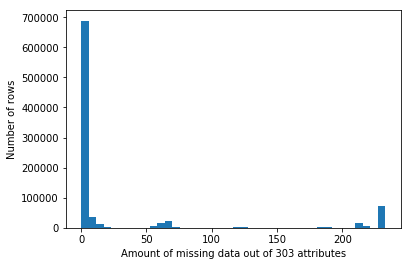

In [16]:
ax = azdias_reduced["n_missing"].plot(kind='hist', bins=40)
ax.set_xlabel("Amount of missing data out of {} attributes".format(azdias_reduced.shape[1]))
ax.set_ylabel("Number of rows")

In [17]:
#divide the data into two subsets based on the number of missing
# values in each row.
#We will separate at 25 missing attributes
azdias_few_nan = azdias_reduced[azdias_reduced["n_missing"]<= 25].drop("n_missing", axis=1)
azdias_nan = azdias_reduced[azdias_reduced["n_missing"]> 25].drop("n_missing", axis=1)

print(azdias_few_nan.shape)
print(azdias_nan.shape)

(737235, 302)
(153986, 302)


Comparison of distribution of values for columns where there are no missing values between No NaN and droped NaN subsets.


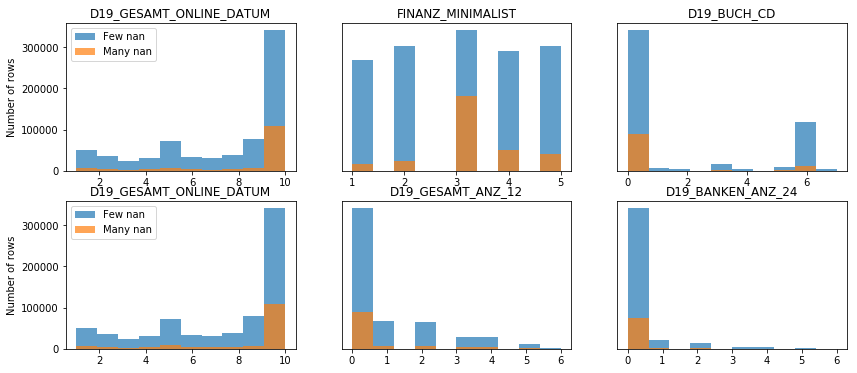

In [20]:
# Compare the distribution of values for at least six columns where there are
# no or few missing values, between the two subsets.
#list of attributes with no missing values
attribute_list  = sorted_missing_info[sorted_missing_info['final_missing']<200]['Attribute'].values
#print(attribute_list)

print("Comparison of distribution of values for columns where there are no missing values between No NaN and droped NaN subsets.")
etl.plot_distribution_comparison(azdias_few_nan, "Few nan", azdias_nan, "Many nan", attribute_list) 

The maximum number of missing data in each row is 233 attributes out of 303 attributes. The distribution of amount of missing data in each row demonstrates that mosst of the rows has less than 25 missing attribute. So, the data was devided into two subsets: azdias_few_nan with <=25 missing attributes (737235 rows) and azdias_nan with >25 missing attributes ( 153986 rows). Comparison of distribution of values for 6 randomly choosen columns demonstrates that there is similar distribution in two data_sets with few missing values (Few Nans) and a lot of NaNs (Nans) 


### Clean and enginner new features using clean function###

#### Attributes that needs engineering####
Engineering of these attributes was included in clean_data function

In [21]:
engineered_attributes = list(np.intersect1d(att_type[att_type["action"].isin(["engineering"])]["attribute"].values, azdias.columns))
print("Attributes that need engineering: \n"
      "{}.".format(engineered_attributes))
print("")


Attributes that need engineering: 
['CAMEO_INTL_2015', 'EINGEFUEGT_AM', 'OST_WEST_KZ', 'PLZ8_BAUMAX', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE'].



In [22]:
azdias_cleaned = etl.clean_data(azdias)
azdias_cleaned.shape

Convert missing value codes into NaNs
Attribute BIP_FLAG is not available in DataFrame.
Attribute CAMEO_DEUINTL_2015 is not available in DataFrame.
Attribute D19_KK_KUNDENTYP is not available in DataFrame.
Attribute GEOSCORE_KLS7 is not available in DataFrame.
Attribute HAUSHALTSSTRUKTUR is not available in DataFrame.
Attribute KBA13_CCM_1400_2500 is not available in DataFrame.
Attribute SOHO_FLAG is not available in DataFrame.
Attribute WACHSTUMSGEBIET_NB is not available in DataFrame.
Attribute D19_BUCH is not available in DataFrame.
Attribute D19_KINDERARTIKELD19_KOSMETIK is not available in DataFrame.
Drop columns with more than 30% of missing values
Drop columns indicated in attribute_types.csv file
Remove rows with more than 25 missing attributes
Reencode OST_WEST_KZ attribute
Change EINGEFUEGT_AM to year
Engineer PRAEGENDE_JUGENDJAHRE
Engineer CAMEO_INTL_2015
Engineer WOHNLAGE
Engineer PLZ8_BAUMAX


(737235, 305)

### Select different types of data

Identify attributes that correspond to different types:

- log_transform attributes (numeric continuous attributes with skew_value >1.0  that need log transform)
- binary_attributes
- categorical_attributes (one hot encode required)
- numeric_attributes (numeric interval data,  ordinal(make the simplifying assumption that the ordinal variables can be treated as being interval in nature)



Continuous attributes distribution ['ANZ_HAUSHALTE_AKTIV' 'ANZ_PERSONEN' 'EINGEZOGENAM_HH_JAHR'
 'KBA13_ANZAHL_PKW' 'MIN_GEBAEUDEJAHR']
ANZ_HAUSHALTE_AKTIV skew_value = 8.73402870740657.


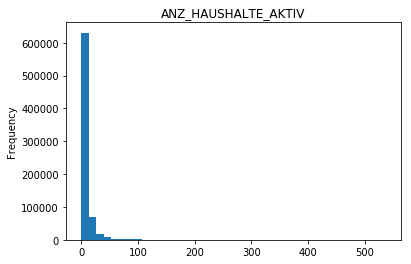

ANZ_PERSONEN skew_value = 1.7651843121005266.


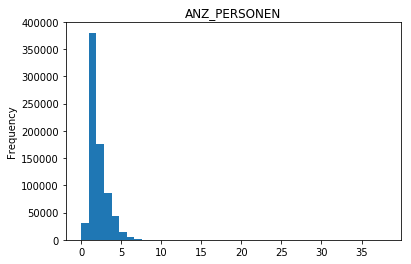

EINGEZOGENAM_HH_JAHR skew_value = 0.22025109510697183.


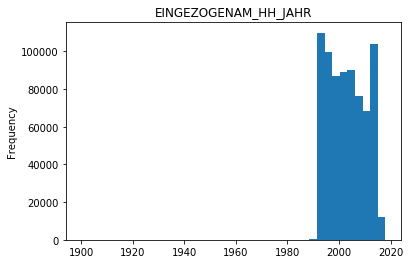

KBA13_ANZAHL_PKW skew_value = 1.265253431219012.


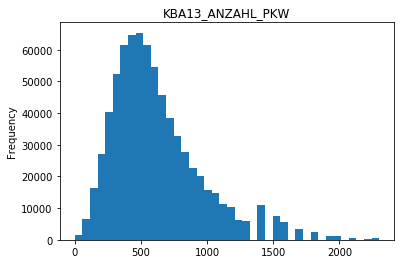

MIN_GEBAEUDEJAHR skew_value = 3.063678733216271.


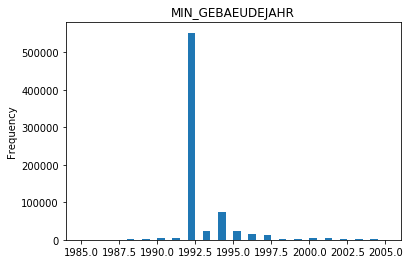

Numerical attributes that need to be log transformed: 
['ANZ_HAUSHALTE_AKTIV', 'ANZ_PERSONEN', 'KBA13_ANZAHL_PKW', 'MIN_GEBAEUDEJAHR'].

Binary attributes: 
['DSL_FLAG', 'GREEN_AVANTGARDE', 'HH_DELTA_FLAG', 'KBA05_SEG6', 'KONSUMZELLE', 'OST_WEST_KZ', 'SOHO_KZ', 'UNGLEICHENN_FLAG', 'VERS_TYP', 'ANREDE_KZ', 'MOVEMENT', 'RURAL_NEIGHBORHOOD', 'PLZ8_BAUMAX_BUSINESS'].

Categorical attributes that need to be Re-Encoded: 
['AKT_DAT_KL', 'ARBEIT', 'CJT_GESAMTTYP', 'CJT_KATALOGNUTZER', 'D19_KONSUMTYP', 'FINANZTYP', 'GEBAEUDETYP_RASTER', 'GEMEINDETYP', 'GFK_URLAUBERTYP', 'HEALTH_TYP', 'KBA05_HERSTTEMP', 'KBA05_MAXHERST', 'KBA13_BAUMAX', 'MOBI_RASTER', 'RT_KEIN_ANREIZ', 'RT_SCHNAEPPCHEN', 'RT_UEBERGROESSE', 'SHOPPER_TYP', 'STRUKTURTYP', 'UMFELD_ALT', 'VHA', 'ZABEOTYP'].



In [23]:
log_attributes, bin_attributes, cat_attributes, num_attributes = etl.select_attributes_by_type(azdias_cleaned)

print("Numerical attributes that need to be log transformed: \n"
      "{}.".format(log_attributes))
print("")

print("Binary attributes: \n"
      "{}.".format(bin_attributes))
print("")

print("Categorical attributes that need to be Re-Encoded: \n"
      "{}.".format(cat_attributes))
print("")



### ETL Pipeline ###
- log_attributes: log -> impute median -> standard scaler
- bin_attributes: impute most frequent
- cat_attributes: dummies transformer (keep all dummy columns, missing values are zeros)
- num_attributes: impute median -> standard scaler

#### log_attributes pipeline ###

In [24]:
log_transform = ('log_transform', FunctionTransformer(func = np.log1p, inverse_func=np.expm1, validate=False))
log_impute = ('log_impute', SimpleImputer(missing_values=np.nan, strategy='median'))
log_scale = ('log_scale', StandardScaler())

log_pipeline = Pipeline([log_transform, log_impute, log_scale])


####  Binary attributes pipeline ###

In [25]:
binary_pipeline = Pipeline([('binary_impute', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))])

#### Categorical attributes pipeline ###

In [26]:
cat_pipeline = Pipeline([('cat_dummy', etl.DummiesTransformer())])

#### Numerical Attributes Pipeline ###

In [27]:
num_impute = ('num_impute', SimpleImputer(missing_values=np.nan, strategy='median'))
num_scale = ('num_scale', StandardScaler())

num_pipeline = Pipeline([num_impute, num_scale])

#### Combining all column transformations

In [28]:
transformers = [('log', log_pipeline, log_attributes),
                ('binary', binary_pipeline, bin_attributes),
                ('cat', cat_pipeline, cat_attributes),
                ('num', num_pipeline, num_attributes)]

ct = ColumnTransformer(transformers=transformers)

azdias_transformed = ct.fit_transform(azdias_cleaned)
azdias_transformed.shape

(737235, 410)

In [29]:
#obtain dummies column names
pl = ct.named_transformers_['cat']
cd = pl.named_steps['cat_dummy']
dummies_names = list(cd.get_feature_names())

#all columns for transformed data
column_names = list(log_attributes)+list(bin_attributes)+dummies_names+list(num_attributes)

#create transformed DataFrame
azdias_transformed = pd.DataFrame(azdias_transformed, columns = column_names)

In [30]:
print("All columns are numeric = {}".format(etl.check_columns_numeric(azdias_transformed)))
azdias_transformed.describe()

All columns are numeric = True


,ANZ_HAUSHALTE_AKTIV,ANZ_PERSONEN,KBA13_ANZAHL_PKW,MIN_GEBAEUDEJAHR,DSL_FLAG,GREEN_AVANTGARDE,HH_DELTA_FLAG,KBA05_SEG6,KONSUMZELLE,OST_WEST_KZ,...,SEMIO_VERT,UMFELD_JUNG,VHN,W_KEIT_KIND_HH,WOHNDAUER_2008,ALTERSKATEGORIE_GROB,GENERATION_DECADE,WEALTH,LIFE_AGE,PLZ8_BAUMAX_FAMILY
count,7.372350e+05,7.372350e+05,7.372350e+05,7.372350e+05,737235.000000,737235.000000,737235.00000,737235.000000,737235.000000,737235.000000,...,7.372350e+05,7.372350e+05,7.372350e+05,7.372350e+05,7.372350e+05,7.372350e+05,7.372350e+05,7.372350e+05,7.372350e+05,7.372350e+05
mean,-1.177310e-15,-1.603202e-16,-2.773428e-15,1.671020e-12,0.989195,0.223602,0.09074,0.118951,0.236927,0.789763,...,-2.291807e-15,-3.215782e-15,6.465103e-15,1.796641e-14,-3.260760e-15,6.080414e-16,1.900087e-15,1.007804e-14,-1.741958e-15,1.050926e-14
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,0.103385,0.416658,0.28724,0.323731,0.425198,0.407477,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.896013e+00,-2.412959e+00,-1.112358e+01,-4.248870e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,-1.679638e+00,-2.711424e+00,-2.085911e+00,-1.865133e+00,-3.687983e+00,-1.682068e+00,-2.292298e+00,-1.560679e+00,-1.258111e+00,-1.294381e+00
25%,-6.831911e-01,-6.150039e-01,-5.807664e-01,-3.893518e-01,1.000000,0.000000,0.00000,0.000000,0.000000,1.000000,...,-1.161781e+00,-9.086758e-01,-3.550289e-01,-6.892201e-01,1.831876e-02,-7.570140e-01,-9.038994e-01,-8.770721e-01,-1.258111e+00,-3.156559e-01
50%,-1.192610e-01,-6.150039e-01,4.765952e-02,-3.893518e-01,1.000000,0.000000,0.00000,0.000000,0.000000,1.000000,...,3.917930e-01,-7.301616e-03,-3.550289e-01,-1.012637e-01,5.477904e-01,1.680402e-01,-2.097000e-01,4.901421e-01,8.779949e-02,-3.156559e-01
75%,6.459444e-01,4.367321e-01,6.604993e-01,-3.893518e-01,1.000000,0.000000,0.00000,0.000000,0.000000,1.000000,...,9.096508e-01,8.940726e-01,5.104123e-01,1.074649e+00,5.477904e-01,1.093094e+00,1.178699e+00,1.173749e+00,7.607546e-01,-3.156559e-01
max,5.043465e+00,7.089955e+00,2.585413e+00,6.742495e+00,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,...,1.427509e+00,8.940726e-01,1.375854e+00,1.074649e+00,5.477904e-01,5.718365e+00,1.178699e+00,1.173749e+00,1.433710e+00,2.620521e+00


### Check outliers in numerical and log transformed attributes###
Use Tukey rule to detect and remove outliers outside of the InterQuartile range (IQR): IQR = Q3 - Q1

In [31]:
#new data frame without outliers
azdias_outlier_removed = azdias_transformed.copy()

outlier_attributes = log_attributes#np.append(log_attributes, num_attributes) 

#dictionary of number of outlier by column_name
outlier_attributes_dict = {}
#print(azdias_outlier_removed.shape)

for column in outlier_attributes:
    previous_len = azdias_outlier_removed.shape[0]
    azdias_outlier_removed = etl.tukey_rule(azdias_outlier_removed, column)
    outlier_attributes_dict[column] = previous_len - azdias_outlier_removed.shape[0] 
    #print(azdias_outlier_removed.shape)
    
outlier_attributes_dict

{'ANZ_HAUSHALTE_AKTIV': 9232,
 'ANZ_PERSONEN': 50952,
 'KBA13_ANZAHL_PKW': 11606,
 'MIN_GEBAEUDEJAHR': 164818}

There are too many outlier. These outliers will be kept, otherwise more than 30% of data will be lost.

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### PCA 

Current number of features:  410


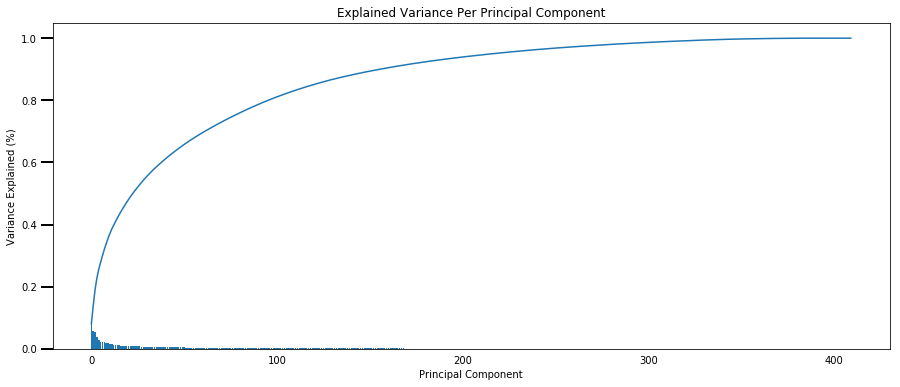

In [32]:
# Apply PCA to the data.
print("Current number of features: ", azdias_transformed.shape[1])
pca = PCA()
azdias_pca = pca.fit_transform(azdias_transformed)
#sum(pca.explained_variance_ratio_)
usml.scree_plot(pca)

There is a visual reduction in explained variance after ~175 principal components. 

In [33]:
n_components = 175
print("Explained variance ratio for the first {} components is {}%.".
      format(n_components, sum(pca.explained_variance_ratio_[:n_components]).round(2)*100))

Explained variance ratio for the first 175 components is 92.0%.


Explained variance ratio: 92.0
Azdias shape (737235, 175).


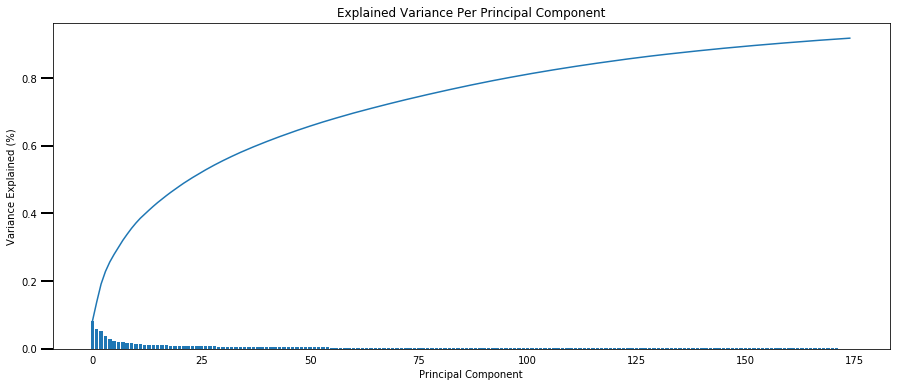

In [34]:
pca = PCA(n_components)
azdias_pca = pca.fit_transform(azdias_transformed)
explained_var_ratio = sum(pca.explained_variance_ratio_)
print("Explained variance ratio:", explained_var_ratio.round(2)*100)

print("Azdias shape {}.".format(azdias_pca.shape))
usml.scree_plot(pca)


In [35]:
# Map weights for the first principal component to corresponding feature names
component = 0
feature_weights = usml.map_component_to_features(pca, component, column_names)

print("Variance of first component:", pca.explained_variance_ratio_[component].round(2)*100)
print("The most five important features with positive weights and the most five "
      "important features with negative weights:")
print(feature_weights[:5])
print(feature_weights[-5:])

Variance of first component: 8.0
The most five important features with positive weights and the most five important features with negative weights:
                     weight
CAMEO_DEUG_2015        0.15
HH_EINKOMMEN_SCORE     0.15
WEALTH                 0.15
ANZ_HAUSHALTE_AKTIV    0.15
KBA13_ANTG3            0.14
                weight
KBA05_AUTOQUOT   -0.14
LP_STATUS_GROB   -0.14
KBA13_ANTG1      -0.15
KBA05_ANTG1      -0.15
MOBI_REGIO       -0.16


In [36]:
# Map weights for the second principal component to corresponding feature names
component = 1
feature_weights = usml.map_component_to_features(pca, component, column_names)
print("Variance of second component:", pca.explained_variance_ratio_[component].round(2)*100)
print("The most five important features with positive weights and the most five "
      "important features with negative weights:")
print(feature_weights[:5])
print(feature_weights[-5:])

Variance of second component: 6.0
The most five important features with positive weights and the most five important features with negative weights:
                             weight
KBA13_HERST_BMW_BENZ           0.19
KBA13_SEG_OBEREMITTELKLASSE    0.16
KBA13_MERCEDES                 0.16
KBA13_BMW                      0.16
KBA13_SITZE_4                  0.15
                      weight
KBA13_KMH_180          -0.12
KBA13_HALTER_20        -0.12
KBA13_SEG_KLEINWAGEN   -0.13
KBA13_KMH_140_210      -0.14
KBA13_SITZE_5          -0.15


In [37]:
# Map weights for the third principal component to corresponding feature names
component = 2 
feature_weights = usml.map_component_to_features(pca, component, column_names)
print("Variance of second component:", pca.explained_variance_ratio_[component].round(2)*100)
print("The most five important features with positive weights and the most five "
      "important features with negative weights:")
print(feature_weights[:5])
print(feature_weights[-5:])

Variance of second component: 5.0
The most five important features with positive weights and the most five important features with negative weights:
                   weight
GENERATION_DECADE    0.20
CJT_TYP_1            0.19
CJT_TYP_2            0.19
FINANZ_SPARER        0.19
ONLINE_AFFINITAET    0.18
                      weight
ALTERSKATEGORIE_GROB   -0.17
CJT_TYP_4              -0.17
FINANZ_VORSORGER       -0.17
CJT_TYP_5              -0.18
KOMBIALTER             -0.19


### Explanation for first principal components

- component 1:
The most prominent features are CAMEO_DEUG_2015, HH_EINKOMMEN_SCORE, WEALTH
The most prominent negative features are MOBI_REGIO, KBA13_ANTG1, KBA05_ANTG1
So, the first principal component is associated with size, wealth and type of family, larger family, 
Higher component corresponds to income, wealth. Negative values: the component is reciprocal to higher probability of share units with other families and low mobility.

- component 2: 
The most prominent features are KBA13_HERST_BMW_BENZ, KBA13_SEG_OBEREMITTELKLASSE, KBA13_MERCEDES, KBA13_BMW
The most prominent negative features is KBA13_SITZE_5
This component is associated with possesing expencive car.

- component 3: 
The most prominent features are GENERATION_DECADE, CJT_TYP_1, CJT_TYP_2, FINANZ_SPARER
The most prominent negative features are KOMBIALTER and CJT_TYP_5
This component is associated with age and customer and financial typology. Higher component relates to higher probability of people being higher age and money savers

### Clustering

In [38]:
# visualize within-cluster distance across number of clusters.

#batch size of minibatch
batch_size=40000

scores = []
centers = list(range(1,31, 1))
for center in centers:
    #print(center)
    scores.append(usml.get_kmeans_score(azdias_pca, center, batch_size))

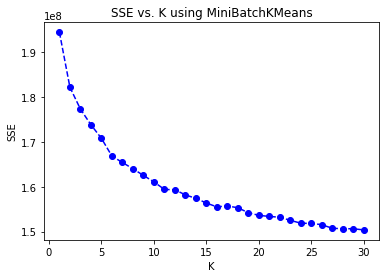

In [39]:
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K using MiniBatchKMeans');

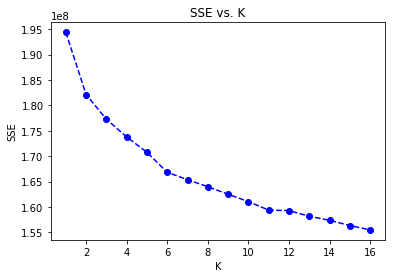

In [60]:
plt.plot(centers[:16], scores[:16], linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

To identify an ideal number of clusters the Elbow plot was created for the number of clusters from 1 to 30. In this plot, the clustering was created using MiniBatchKmeans methos with batch size=40000 The average within-cluster distances plotted against number of components demonstrates that the score was rapidly decreased for the first 16 components and continue to decrease for higher number of clusters but with lower slope. 16 clusters were selected.

### Combine ETL pipeline with PCA and KMeans steps


In [50]:
n_components = 175
n_clusters = 16
cluster_pipeline = Pipeline([
                        ('transform', ct), 
                        ('pca', PCA(n_components)),
                        ('kmeans', KMeans(n_clusters=n_clusters, random_state=42) )
                        ])

In [51]:
cluster_pipeline.fit(azdias_cleaned)
general_predictions = cluster_pipeline.predict(azdias_cleaned)
general_predictions[:20]

array([ 7,  1,  4, 14,  6,  0,  0, 10, 10,  3,  0,  0, 10,  7,  7,  0, 15,
        6,  6,  5], dtype=int32)

In [53]:
# Save to file in the current working directory
pkl_filename = "unsupervised_model_16_clusters.pkl"  
with open(pkl_filename, 'wb') as file:  
    pickle.dump(cluster_pipeline, file)

In [54]:
# Load from file
#with open(pkl_filename, 'rb') as file:  
#    pickle_model = pickle.load(file)
    
#cluster_pipeline = pickle_model
#general_predictions = cluster_pipeline.predict(azdias_cleaned)
#general_predictions[:20]

In [55]:
print("Customers Data: Cleaning \n")
customers_cleaned = etl.clean_data(customers)
print("")
print("Customers Data: Cluster Predictions \n")
customers_predictions = cluster_pipeline.predict(customers_cleaned)
customers_predictions[:20]

Customers Data: Cleaning 

Convert missing value codes into NaNs
Attribute BIP_FLAG is not available in DataFrame.
Attribute CAMEO_DEUINTL_2015 is not available in DataFrame.
Attribute D19_KK_KUNDENTYP is not available in DataFrame.
Attribute GEOSCORE_KLS7 is not available in DataFrame.
Attribute HAUSHALTSSTRUKTUR is not available in DataFrame.
Attribute KBA13_CCM_1400_2500 is not available in DataFrame.
Attribute SOHO_FLAG is not available in DataFrame.
Attribute WACHSTUMSGEBIET_NB is not available in DataFrame.
Attribute D19_BUCH is not available in DataFrame.
Attribute D19_KINDERARTIKELD19_KOSMETIK is not available in DataFrame.
Drop columns with more than 30% of missing values
Drop columns indicated in attribute_types.csv file
Remove rows with more than 25 missing attributes
Reencode OST_WEST_KZ attribute
Change EINGEFUEGT_AM to year
Engineer PRAEGENDE_JUGENDJAHRE
Engineer CAMEO_INTL_2015
Engineer WOHNLAGE
Engineer PLZ8_BAUMAX

Customers Data: Cluster Predictions 



array([ 6,  6,  6, 12, 10,  8,  6, 15,  8,  8,  8, 15,  6,  8, 14,  5,  8,
        1,  4, 15], dtype=int32)

In [56]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

dfbar = pd.DataFrame(columns=['clusters','type'])
dfbar['clusters'] = np.append(general_predictions, customers_predictions)
dfbar['type'] = ['general']*len(general_predictions) + ['customers']*len(customers_predictions)

general_counts = np.array(dfbar['clusters'].loc[dfbar['type'] == 'general'].value_counts().
                          sort_index(ascending=True))
customers_counts = np.array(dfbar['clusters'].loc[dfbar['type'] == 'customers'].value_counts().
                            sort_index(ascending=True))

print("General counts: {}".format(general_counts))
print("Customers counts: {}".format(customers_counts))

general_ratio = general_counts/len(general_predictions)
customers_ratio = customers_counts/len(customers_predictions)
print("General ratio: {}".format(general_ratio.round(2)))
print("Customers ratio: {}".format(customers_ratio.round(2)))

General counts: [69081 57996 31124 54307 53409 39017 67050 55061 54873 39518 35792 29287
 38187 46033 30602 35898]
Customers counts: [ 1109  7831  2716  8964 12393  1422 32673   385 33445  2745 15591   276
  2439  3174  4501  4581]
General ratio: [0.09 0.08 0.04 0.07 0.07 0.05 0.09 0.07 0.07 0.05 0.05 0.04 0.05 0.06
 0.04 0.05]
Customers ratio: [0.01 0.06 0.02 0.07 0.09 0.01 0.24 0.   0.25 0.02 0.12 0.   0.02 0.02
 0.03 0.03]


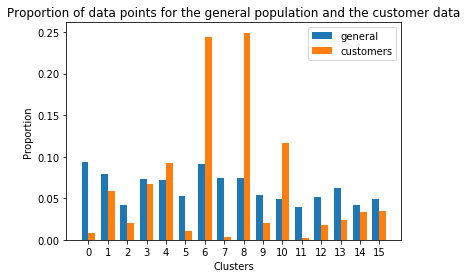

In [57]:
index = np.arange(n_clusters)
bar_width = 0.35

fig, ax = plt.subplots()

#print(len(customers_ratio))
ax.bar(index, general_ratio, bar_width, label = "general")
ax.bar(index+bar_width, customers_ratio, bar_width, label = "customers")

ax.set_xlabel('Clusters')
ax.set_ylabel('Proportion')
ax.set_title('Proportion of data points for the general population and the customer data')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(index)
ax.legend()

#fig.tight_layout()
plt.show()

[Text(0,0,'0'),
 Text(0,0,'1'),
 Text(0,0,'2'),
 Text(0,0,'3'),
 Text(0,0,'4'),
 Text(0,0,'5'),
 Text(0,0,'6'),
 Text(0,0,'7'),
 Text(0,0,'8'),
 Text(0,0,'9'),
 Text(0,0,'10'),
 Text(0,0,'11'),
 Text(0,0,'12'),
 Text(0,0,'13'),
 Text(0,0,'14'),
 Text(0,0,'15')]

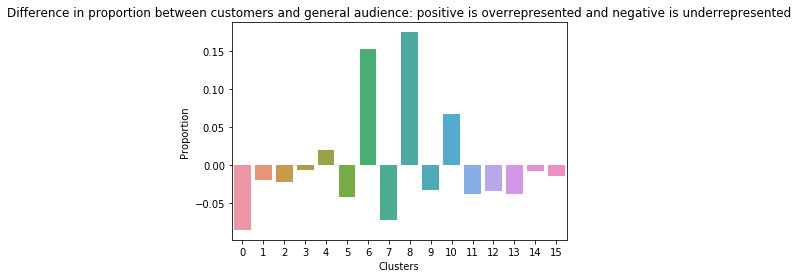

In [58]:
#plot the difference in proportion between customers and general audience.
#positive - overrepresented customers data
#negative - underrepresented customers data
diff_ratio = customers_ratio - general_ratio
index = np.arange(n_clusters)
bar_width = 0.35
fig, ax = plt.subplots()

ax = sns.barplot(x = index, y = diff_ratio)
ax.set_xlabel('Clusters')
ax.set_ylabel('Proportion')
ax.set_title('Difference in proportion between customers and general audience: positive is overrepresented and negative is underrepresented')
ax.set_xticks(index)
ax.set_xticklabels(index)

In [59]:
cluster_centers_df = usml.get_clusters_attributes(cluster_pipeline, num_attributes, log_attributes, column_names)
cluster_centers_df

,ANZ_HAUSHALTE_AKTIV,ANZ_PERSONEN,KBA13_ANZAHL_PKW,MIN_GEBAEUDEJAHR,DSL_FLAG,GREEN_AVANTGARDE,HH_DELTA_FLAG,KBA05_SEG6,KONSUMZELLE,OST_WEST_KZ,...,SEMIO_VERT,UMFELD_JUNG,VHN,W_KEIT_KIND_HH,WOHNDAUER_2008,ALTERSKATEGORIE_GROB,GENERATION_DECADE,WEALTH,LIFE_AGE,PLZ8_BAUMAX_FAMILY
0,3.265456,1.349057,664.796470,1992.806590,0.994156,0.195479,0.085069,0.138775,0.141544,0.937002,...,4.000341,3.863381,2.244682,3.950432,7.622189,1.933771,8.569902,2.614185,3.143799,1.038593
1,8.225760,1.200355,679.165745,1992.353117,1.000053,0.057509,0.068168,0.069903,0.275226,0.928452,...,3.990659,3.989651,2.544711,4.777590,8.174603,3.368938,6.465558,3.753241,2.783262,1.185545
2,9.847369,1.316771,432.679382,1993.066522,0.971346,0.027517,0.062633,0.017573,0.209724,0.060783,...,4.266820,4.079332,2.316560,5.036629,8.302031,3.653623,5.991337,4.441522,3.298965,2.335565
3,8.558025,1.258957,465.337064,1992.176083,0.996344,0.060863,0.071900,0.068082,0.290914,0.880429,...,4.237538,3.843663,2.666044,5.039783,8.333723,3.537039,6.121716,4.479759,2.389921,2.118693
4,1.809883,1.498131,519.720401,1993.063351,0.979454,0.162799,0.096320,0.106541,0.039830,0.963214,...,4.352493,4.323473,2.023555,4.308762,8.378119,3.388595,6.587723,2.399964,3.085843,0.996149
5,14.315453,1.161432,328.392836,1992.280165,0.991261,0.047714,0.065741,0.045483,0.757116,0.662067,...,4.030771,3.239717,2.975014,4.686824,7.618622,2.442227,7.894334,4.650926,1.343492,1.096937
6,1.708209,1.441720,668.159498,1992.575807,0.998102,0.535070,0.098651,0.193066,0.110064,0.939907,...,4.742374,4.379826,2.298038,4.863833,8.534042,3.536953,6.010401,2.226087,3.599142,1.069290
7,9.098969,1.245487,537.790862,1992.213566,0.998307,0.051973,0.080429,0.065881,0.281108,0.928026,...,3.877020,3.551383,2.523769,4.227901,7.591986,1.898943,8.523454,4.445012,2.075501,1.825744
8,1.577107,2.496535,645.044169,1992.899451,0.993107,0.497659,0.138764,0.153411,0.087875,0.928560,...,4.593364,4.376006,2.175926,3.444627,8.602344,3.380380,6.622760,2.219613,3.396483,1.060609
9,1.942889,1.682571,383.377911,1993.985327,0.935386,0.115190,0.086729,0.062998,0.043201,0.118394,...,4.487380,4.397579,2.195016,4.098469,8.289113,3.050918,7.000698,2.753019,3.463310,1.061114


In [61]:
#count from 0
interested_1 = 6
interested_2 = 8

nointerest_1 = 0
nointerest_2 = 7
print("Comparison DataFrame, first two columns are  interested clusters and the last two are not interested")
comparison_df = pd.concat([cluster_centers_df.T[interested_1], cluster_centers_df.T[interested_2],
           cluster_centers_df.T[nointerest_1], cluster_centers_df.T[nointerest_2]], axis=1)

Comparison DataFrame, first two columns are  interested clusters and the last two are not interested


In [62]:
#display only different columns
print("Comparison DataFrame: first two columns are  interested clusters and the last two are not interested")
print("Attributes only with more than 0.5 std are displayed")
comparison_df.rename(columns={6:'interested_{}'.format(interested_1), 
                              8:'interested_{}'.format(interested_2), 
                              0:'nointerest_{}'.format(nointerest_1), 
                              7:'nointerest_{}'.format(nointerest_2), 
                             }, inplace=True)

comparison_df_std = comparison_df[comparison_df.std(axis=1) > 0.5]
comparison_df_std


Comparison DataFrame: first two columns are  interested clusters and the last two are not interested
Attributes only with more than 0.5 std are displayed


,interested_6,interested_8,nointerest_0,nointerest_7
ANZ_HAUSHALTE_AKTIV,1.708209,1.577107,3.265456,9.098969
ANZ_PERSONEN,1.441720,2.496535,1.349057,1.245487
KBA13_ANZAHL_PKW,668.159498,645.044169,664.796470,537.790862
ANZ_STATISTISCHE_HAUSHALTE,2.057676,2.099312,3.748454,12.243028
BALLRAUM,4.306080,4.732857,4.808404,3.582340
CAMEO_DEUG_2015,3.720174,3.758573,4.442761,7.555076
CJT_TYP_1,2.068813,2.445325,4.505007,4.609500
CJT_TYP_2,1.781439,2.043864,4.259462,4.632179
CJT_TYP_3,4.328467,4.122730,2.323566,2.021598
CJT_TYP_4,4.370224,3.809099,2.357814,2.520298


In [63]:
azdias_cleaned['cluster'] = general_predictions

Index(['ANZ_HAUSHALTE_AKTIV', 'KBA13_ANZAHL_PKW', 'ANZ_STATISTISCHE_HAUSHALTE',
       'CAMEO_DEUG_2015', 'CJT_TYP_1', 'CJT_TYP_2', 'CJT_TYP_3', 'CJT_TYP_5',
       'CJT_TYP_6', 'D19_BUCH_CD', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24',
       'D19_GESAMT_DATUM', 'D19_GESAMT_OFFLINE_DATUM',
       'D19_GESAMT_ONLINE_DATUM', 'D19_GESAMT_ONLINE_QUOTE_12',
       'D19_KONSUMTYP_MAX', 'D19_KOSMETIK', 'D19_REISEN', 'D19_VERSAND_ANZ_12',
       'D19_VERSAND_ANZ_24', 'D19_VERSAND_DATUM', 'D19_VERSAND_OFFLINE_DATUM',
       'D19_VERSAND_ONLINE_DATUM', 'D19_VERSAND_ONLINE_QUOTE_12',
       'EINGEZOGENAM_HH_JAHR', 'FINANZ_ANLEGER', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_VORSORGER',
       'HH_EINKOMMEN_SCORE', 'KBA05_ANTG1', 'KOMBIALTER', 'LP_STATUS_GROB',
       'MOBI_REGIO', 'ORTSGR_KLS9', 'SEMIO_LUST', 'SEMIO_MAT', 'SEMIO_PFLICHT',
       'SEMIO_RAT', 'SEMIO_REL', 'SEMIO_TRADV', 'GENERATION_DECADE', 'WEALTH'],
      dtype='object')


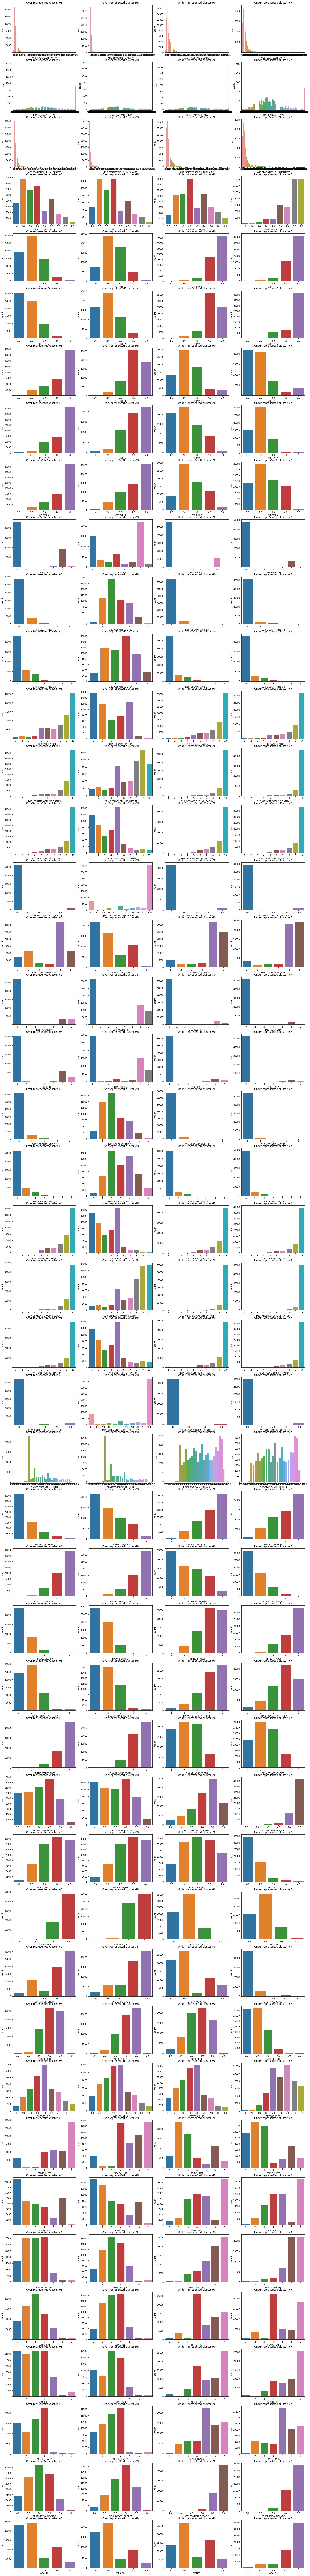

In [64]:
columns = comparison_df[comparison_df.std(axis=1) > 1.0].index
print(columns)
n_rows = len(columns)

fig, axes = plt.subplots(nrows=n_rows, ncols=4, figsize=(25,5*n_rows))
n =0
for column in columns[:n_rows]:
    
    sns.countplot(azdias_cleaned[azdias_cleaned['cluster']==interested_1][column], ax=axes[n,0] )
    axes[n,0].set_title('Over represented cluster #{}'.format(interested_1))
    sns.countplot(azdias_cleaned[azdias_cleaned['cluster']==interested_2][column], ax=axes[n,1] )
    axes[n,1].set_title('Over represented cluster #{}'.format(interested_2))
    
    sns.countplot(azdias_cleaned[azdias_cleaned['cluster']==nointerest_1][column], ax=axes[n,2] )
    axes[n,2].set_title('Under represented cluster #{}'.format(nointerest_1))
    sns.countplot(azdias_cleaned[azdias_cleaned['cluster']==nointerest_2][column], ax=axes[n,3] )
    axes[n,3].set_title('Under represented cluster #{}'.format(nointerest_2))
    n += 1

### Compare Customer Data to Demographics Data
The analysis of general audience and customers demonstrates that there are clusters with overrepresentation as well as underrepresentation in the customer dataset. 

Clusters with highest positive difference in proportion between customers and general audience is overrepresented in the customer data (Cluster #6, #8). The clusters with highest negative difference in proportion between customers and general audience is underrepresented in the customer data (Cluster #0 and #7). Their cluster centers were mapped out to original features to identify types of people.

So, people that use mail-order company (#6 and #8) are wealth, 45-60 years old (ALTERSKATEGORIE_GROB=~3.4) with 60s average generation decade (GENERATION_DECADE = 6.1, 6.6 respectively), money savers or investors with high probability (FINANZ_SPARER=1.3 and 1.6 respectevely). They are high earners (LP_STATUS_GROB=4) vs  low earners (1.2 and 2.3) in under represented cluster. These people are with low movement pattern (MOBI_REGIO=4.2). These people are also religious and traditional minded.

There are also some difference between two over represented clusters in such categories as D19_GESAMT_DATUM (8.2 vs 2.8), D19_KINDERARTIKEL (0.6 vs 2.2), D19_VERSAND_DATUM (9.0 va 3.3), D19_KONSUMTYP_MAX (6.1 vs 2.1). Not all of the leasted features have description but overall  D19_* features are related to frequency of using certain group of products. Thus the clussifier distinguished two groups with high and low transaction activity.

On the other hand, people that are underrepresented in the company are up to 45 years old (ALTERSKATEGORIE_GROB=1.8 and 1.9). These people were born in 80s and 90s (GENERATION_DECADE = 8.6) and have low financial interest (FINANZ_MINIMALIST = 1 and 2). These people are poor, they are money savers with very low probability (FINANZ_SPARER > 3.9). One of the clusters demonstrated that these people have high movement pattern (MOBI_REGIO=1.9) meaning that they don't own homes, and another with middle movement pattern (MOBI_REGIO=3.8). These people are sensual minded with higher probability; and relligious and traditional minded with very low probability.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [70]:
#mailout_train = pd.read_csv('./data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';', low_memory=False)
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';', low_memory=False)

In [71]:
print(mailout_train.shape)
mailout_train["RESPONSE"].value_counts()

(42962, 367)


0    42430
1      532
Name: RESPONSE, dtype: int64

It is notewothy that only ~1.2% of mailout train data set is a customer segment. 

In [74]:
#clean data using clean_data function from unsupervied learning created for general population
mailout_train_cleaned = etl.clean_data(mailout_train, test_data=True)
print(mailout_train_cleaned.shape)

Convert missing value codes into NaNs
Attribute BIP_FLAG is not available in DataFrame.
Attribute CAMEO_DEUINTL_2015 is not available in DataFrame.
Attribute D19_KK_KUNDENTYP is not available in DataFrame.
Attribute GEOSCORE_KLS7 is not available in DataFrame.
Attribute HAUSHALTSSTRUKTUR is not available in DataFrame.
Attribute KBA13_CCM_1400_2500 is not available in DataFrame.
Attribute SOHO_FLAG is not available in DataFrame.
Attribute WACHSTUMSGEBIET_NB is not available in DataFrame.
Attribute D19_BUCH is not available in DataFrame.
Attribute D19_KINDERARTIKELD19_KOSMETIK is not available in DataFrame.
Drop columns with more than 30% of missing values
Drop columns indicated in attribute_types.csv file
Reencode OST_WEST_KZ attribute
Change EINGEFUEGT_AM to year
Engineer PRAEGENDE_JUGENDJAHRE
Engineer CAMEO_INTL_2015
Engineer WOHNLAGE
Engineer PLZ8_BAUMAX
(42962, 306)


In [75]:
#check that all columns are numeric
etl.check_columns_numeric(mailout_train_cleaned)

True

In [76]:
mailout_train_cleaned.shape

(42962, 306)

Starting from here there are two approaches to go:
- split data set to training and validation set 
- use cross validation technique 

I decided to work with cross validation because there is only 532 (1.2%) of the customers. In case of splitting data set, this value will be reduced by 20%.

So, I use 5-fold cross validation in obtaining learning curves and parameterizing model using GridSearchCV.

In [77]:
y_train = mailout_train_cleaned["RESPONSE"]
X_train = mailout_train_cleaned.drop(["RESPONSE"], axis=1)

### Create Pipeline

Pipeline will consist of two steps:  column transformer introduced in preprocessing step and classifier.

#### Models
Several ensemble methods are tested with default parameters to choose the best. Ensemble Learning is method of building a model on top of other models. Random Forest Classifier, Adaboost Classifier and Gradient Boosting Classifier are all ensemble classifiers build on top of Desition tree model (by default).
These ensemble models work great both for classification and for regression problems and in general has the following benefits:
- improves the stability and accuracy of machine learning algorithms 
- reduces variance of a single estimate from one model as they combine several estimates from several models 
- helps to avoid overfitting

#### Metric
ROC_AUC score will be used to evaluate performances of models. AUC provides an aggregate measure of performance across all possible classification thresholds. One way of interpreting AUC is as the probability that the model ranks a random positive example more highly than a random negative example.

#### Model evaluation
For model evaluation I use learning curve method. A learning curve shows the validation and training score of an estimator for varying numbers of training samples 10%-100% of training data. It is a tool to find out how much we benefit from adding more training data and whether the estimator suffers more from a variance error or a bias error. 


In [78]:
models = {'RandomForestClassifier': RandomForestClassifier(random_state=42), 
          'AdaBoostClassifier': AdaBoostClassifier(random_state=42), 
          'GradientBoostingClassifier': GradientBoostingClassifier(random_state=42)
         }

RandomForestClassifier
Roc_auc train score = 0.99
Roc_auc validation score = 0.53



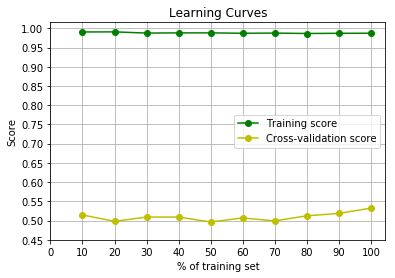

AdaBoostClassifier
Roc_auc train score = 0.84
Roc_auc validation score = 0.72



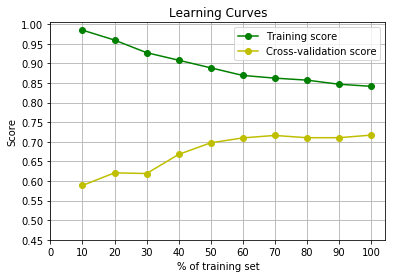

GradientBoostingClassifier
Roc_auc train score = 0.92
Roc_auc validation score = 0.76



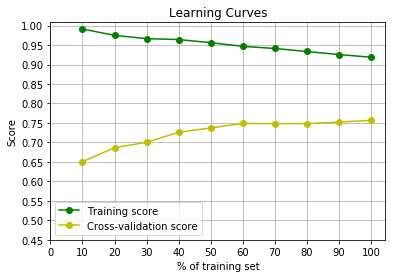

In [81]:
for model_key in models.keys():
    print(model_key)
    pipeline = sml.make_pipeline(ct, models[model_key])
    X2, y2 = sml.randomize(X_train, y_train)
    sml.draw_learning_curves(X2, y2, pipeline, 10)

Random Forest Classifier has a tiny error on train set (roc_auc score=53%) meaning that the model has badly overfit the data. An error on validation set (roc_auc score=53%) is huge, this is a high bias model. Note, that the curves are already converged and adding more data will not improve classifier. This is a high bias model. 

Adaboost Classifier demonstrates better performance. Although training roc_auc score decreases upto 84% with increasing training set size, it increases for validation set upto 72%. The two curves are almost converged and the score will not be sabstantially impoved with increasing number of points in training set. 

The validation score of Gradient Boosting Classifier increases up to (76%) while training score decreases up to 92%. Gradient Boosting Classifier. The two curves are not converged and adding more points can improove score even more.
 

### Grid Search

In the next step the model will be parametrized using Grid Search.
Grid Search tests all possible combination of specified hyperparameters using cross validation and then chooses the model with the maximum score on a validation set.

In [82]:
#initialize pipeline with GradientBoostingClassifier
gbc_pipeline = sml.make_pipeline(ct, GradientBoostingClassifier(random_state=42))

parameters = {'classifier__learning_rate': [0.1, 0.2], 'classifier__n_estimators': [100], 
              'classifier__max_depth': [3, 5], 'classifier__min_samples_split': [2, 4]}
        
        
grid_obj = GridSearchCV(gbc_pipeline, parameters, scoring = 'roc_auc')

# Fit the grid search object to the training data and find the optimal parameters
grid_obj.fit(X_train, y_train)

# Get the estimator and predict
print(grid_obj.best_params_)
best_clf = grid_obj.best_estimator_
best_predictions = best_clf.predict_proba(X_train)[:, 1]

# Make predictions using unoptimized and the best model
predictions = (gbc_pipeline.fit(X_train, y_train)).predict_proba(X_train)[:, 1]

print("Roc_auc score on training data: {:.4f}".format(roc_auc_score(y_train, predictions)))
print("Final Roc_auc score on the training data: {:.4f}".format(roc_auc_score(y_train, best_predictions)))



{'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__min_samples_split': 4, 'classifier__n_estimators': 100}
Roc_auc score on testing data: 0.8976
Final Roc_auc score on the testing data: 0.8968


In [84]:
# Save to file in the current working directory
pkl_filename = "best_gradient_boosting.pkl"  
with open(pkl_filename, 'wb') as file:  
    pickle.dump(best_clf, file)

Text(0.5,0,'feature importance')

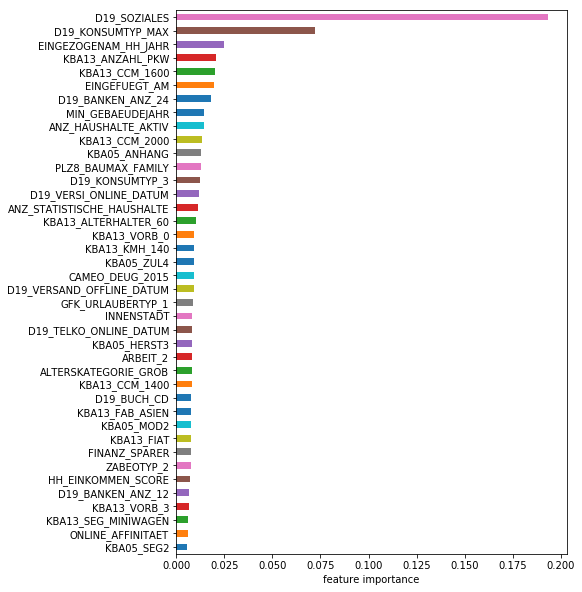

In [85]:
feature_importances = best_clf.named_steps['classifier'].feature_importances_
pd.Series(feature_importances, index=column_names).sort_values()[-40:].plot(kind='barh', figsize=(7,10))
plt.xlabel('feature importance')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [87]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';', low_memory=False)

In [88]:
mailout_test.shape

(42833, 366)

In [89]:
mailout_test_cleaned = etl.clean_data(mailout_test, test_data=True)


Convert missing value codes into NaNs
Attribute BIP_FLAG is not available in DataFrame.
Attribute CAMEO_DEUINTL_2015 is not available in DataFrame.
Attribute D19_KK_KUNDENTYP is not available in DataFrame.
Attribute GEOSCORE_KLS7 is not available in DataFrame.
Attribute HAUSHALTSSTRUKTUR is not available in DataFrame.
Attribute KBA13_CCM_1400_2500 is not available in DataFrame.
Attribute SOHO_FLAG is not available in DataFrame.
Attribute WACHSTUMSGEBIET_NB is not available in DataFrame.
Attribute D19_BUCH is not available in DataFrame.
Attribute D19_KINDERARTIKELD19_KOSMETIK is not available in DataFrame.
Drop columns with more than 30% of missing values
Drop columns indicated in attribute_types.csv file
Reencode OST_WEST_KZ attribute
Change EINGEFUEGT_AM to year
Engineer PRAEGENDE_JUGENDJAHRE
Engineer CAMEO_INTL_2015
Engineer WOHNLAGE
Engineer PLZ8_BAUMAX


In [90]:
# Ensure the order of column in the Azdias set is in the same order that in customers set
mailout_test_cleaned = mailout_test_cleaned[mailout_train_cleaned.drop(["RESPONSE"], axis=1).columns]

print(mailout_train_cleaned.drop(["RESPONSE"], axis=1).shape)
print(mailout_test_cleaned.shape)

(42962, 305)
(42833, 305)


In [91]:
# Load from file
pkl_filename = "best_gradient_boosting.pkl"  
with open(pkl_filename, 'rb') as file:  
    pickle_model = pickle.load(file) 
    
#predict target values
kaggle_predict = pickle_model.predict_proba(mailout_test_cleaned)[:,1]
kaggle_predict

array([0.04521224, 0.02493769, 0.00217057, ..., 0.01343489, 0.04191621,
       0.02398422])

In [92]:
submission = pd.read_csv('../Arvato-Capstone/Arvato_Capstone_Example_Submission.csv')
submission.RESPONSE = kaggle_predict
submission.to_csv('kaggle_submission.csv', index=False)
submission.shape

(42833, 2)

In [93]:
submission.columns

Index(['LNR', 'RESPONSE'], dtype='object')

#### The resulted score on the testing set is 0.78906.